In [1]:
# Calling libraries:
from __future__ import division
%matplotlib inline
import numpy as np, time, matplotlib.pyplot as plt, numpy.random as npr, pystan as ps, pickle
from pylab import plot, show, legend
from time import time
from scipy.stats import *
from tqdm import trange

In [2]:
sm = ps.StanModel(file="model.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_adca34445543ea9daea5f38ba1350097 NOW.


In [3]:
def generate_X(T, k) :
    p, q = 10, 10
    r = max(p,q)
    X = np.zeros((T,k))
    
    for i in range(k) :

        z = np.zeros(T)
        omega = npr.rand()
        beta = npr.rand(p)/(1.2*p)
        alpha = npr.rand(q)/(1.2*q)

        sigsq, z = np.ones(T), np.zeros(T)
        for t in np.arange(0,r) :
            z[t] = np.sqrt(sigsq[t])*npr.randn() 
        for t in np.arange(r,T) :
            sigsq[t] = omega + beta.dot(sigsq[t-p:t]) + alpha.dot((z[t-q:t]**2))
            z[t] = np.sqrt(sigsq[t])*npr.randn()
        
        X[:,i] = sigsq
    
    return X

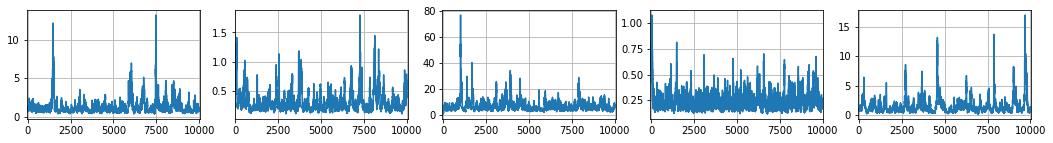

In [26]:
p = 10
T = 10_000
alph = npr.randn(p)
prob = np.zeros(T)
c = -0.1
q = 5
b = npr.randn(q)
X = generate_X(T, q)

f = plt.figure(figsize=(18,2))
for i in range(q) :
    plt.subplot(1,q,i+1)
    plt.plot(X[:,i])
    plt.xlim(-0.005*T,1.005*T)
    plt.grid(True)

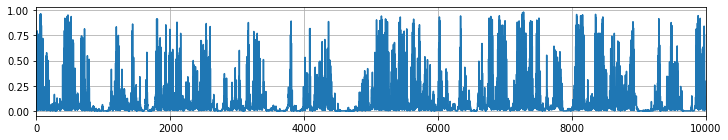

In [27]:
y = np.zeros(T).astype(int)
for t in range(p) :
    prob[t] = 1/(1+np.exp(-(c+X[t].dot(b)))) 
    y[t] = npr.binomial(n=1,p=prob[t],size=1)
for t in np.arange(p+1,T) :
    prob[t] = 1/(1+np.exp(-(c+alph.dot(y[(t-p):t])+X[t].dot(b)))) 
    y[t] = npr.binomial(n=1,p=prob[t],size=1)
    
plt.figure(figsize=(12,2))
plt.plot(prob)
plt.xlim(0,T)
plt.grid(True);

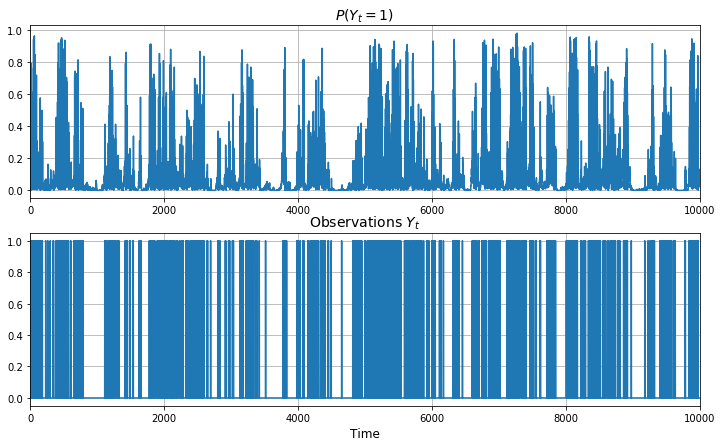

In [61]:
fig = plt.figure(figsize=(12,7))
plt.subplot(211)
plt.plot(prob)
plt.xlim(0,T)
plt.grid(True)
# plt.xticks(alpha=0)
plt.title(r"$P(Y_t=1)$", fontsize=14)
plt.subplot(212)
plt.plot(y)
plt.xlim(0,T)
plt.grid(True)
plt.title(r"Observations $Y_t$", fontsize=14)
plt.xlabel("Time", fontsize=12)

fig.savefig('binary_AR_data.pdf', bbox_inches='tight', dpi=500)

In [56]:
np.mean(prob)

0.10008709689082976

In [60]:
[np.mean(y[i*1000:(i+1)*1000]) for i in range(10)]

[0.13, 0.089, 0.077, 0.048, 0.064, 0.152, 0.095, 0.107, 0.136, 0.091]

In [41]:
dat = dict(y=y, X=X, prob=prob, alpha=alph, b=b, c=c)
file = open("/xtmp/DC-BATS_data/binary_AR/data.pkl", "wb")
pickle.dump(dat, file)
file.close()

### MCMC on full dataset:

In [28]:
n_chains = 10

tstart, tend = 0, T
data = dict(T=tend-tstart, p=p, q=q, y=y[tstart:tend], X=X[tstart:tend,:], power=1)
start = time()
fit = sm.sampling(data=data, thin=1, n_jobs=min(10,n_chains), chains=n_chains, init="random", iter=1_000)
print(round((time()-start)/60,2), "minutes to run")
trace = fit.extract()

11.3 minutes to run


In [29]:
file = open("/xtmp/DC-BATS_data/binary_AR/full_mcmc.pkl", "wb")
pickle.dump(trace, file)
file.close()

### Divide-and-conquer

In [ ]:
m = 10
tstarts = np.arange(m).astype(int)
tends = 1 + tstarts
tstarts *= int(T/m)
tends *= int(T/m)

In [ ]:
for i in range(m) :
    tstart, tend = tstarts[i], tends[i]
    dict(T=tend-tstart, p=p, q=q, y=y[tstart:tend], X=X[tstart:tend,:], power=T/(tend-tstart))
    fit = sm.sampling(data=data, thin=1, n_jobs=min(10,n_chains), chains=n_chains, init="random", iter=1_000)
    trace = fit.extract()
    file = open("/xtmp/DC-BATS_data/binary_AR/mcmc_wb_chunk"+str(i+1)+".pkl", "wb")
    pickle.dump(trace, file)
    file.close()

### Compare:

In [33]:
file = open("/xtmp/DC-BATS_data/binary_AR/full_mcmc.pkl", "rb")
trace = pickle.load(file)
c_ci_full = np.percentile(trace['c'],axis=0,q=[2.5,97.5])
alpha_ci_full = np.percentile(trace['alpha'],axis=0,q=[2.5,97.5])
b_ci_full = np.percentile(trace['b'],axis=0,q=[2.5,97.5])

In [34]:
c_ci_dc = np.zeros(2)
alpha_ci_dc = np.zeros((2,p))
b_ci_dc = np.zeros((2,q))
for i in range(m) :
    file = open("/xtmp/DC-BATS_data/binary_AR/mcmc_wb_chunk"+str(i+1)+".pkl", "rb")
    trace = pickle.load(file)
    c_ci_dc += np.percentile(trace['c'],axis=0,q=[2.5,97.5])/m
    alpha_ci_dc += np.percentile(trace['alpha'],axis=0,q=[2.5,97.5])/m
    b_ci_dc += np.percentile(trace['b'],axis=0,q=[2.5,97.5])/m

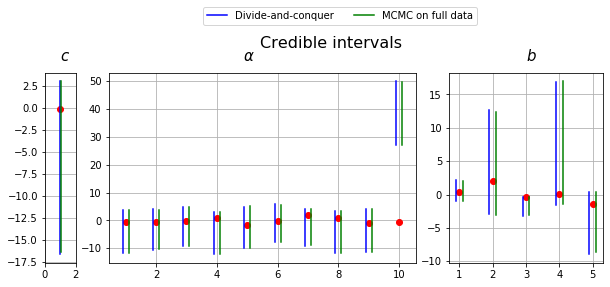

In [90]:
plt.rcParams['axes.grid'] = True
f, (a0, a1, a2) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, p, q]}, figsize=(10,3.5))

a0.plot(1, c, "ro")
a0.plot([0.95,0.95], c_ci_dc, "b-")
a0.plot([1.05,1.05], c_ci_full, "g-")
a0.axis(xmin=0,xmax=2)

a1.plot(np.arange(1,p+1), alph, "ro")
for i in range(p) :
    a1.plot([i+0.9,i+0.9], alpha_ci_dc[:,i], "b-")
    a1.plot([i+1.1,i+1.1], alpha_ci_full[:,i], "g-")

a2.plot(np.arange(1,q+1), b, "ro")
for i in range(q) :
    if i < (q-1) :
        a2.plot([i+0.9,i+0.9], b_ci_dc[:,i], "b-")
        a2.plot([i+1.1,i+1.1], b_ci_full[:,i], "g-")
    if i == (q-1) :
        a2.plot([i+0.9,i+0.9], b_ci_dc[:,i], "b-", label="Divide-and-conquer")
        a2.plot([i+1.1,i+1.1], b_ci_full[:,i], "g-", label="MCMC on full data")
    
plt.text(x=-11, y=20, s=r"$c$", fontsize=15)
plt.text(x=-5.5, y=20, s=r"$\alpha$", fontsize=15)
plt.text(x=3, y=20, s=r"$b$", fontsize=15)
plt.text(x=-5, y=22, s=r"Credible intervals", fontsize=16)
plt.legend(ncol=2, loc=(-1.6,1.25))

f.savefig('binary_AR_CI.pdf', bbox_inches='tight', dpi=500)